<a href="https://colab.research.google.com/github/gudgyo/Test_ML/blob/main/semantic_interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x #because of notebook
!pip install gensim
!pip install nltk

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x #because of notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import re
import nltk
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec, KeyedVectors

from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
#dataset into pandas dataframe
train = pd.read_csv("https://drive.google.com/uc?export=download&id=1ksEJ5lodwquCoQ5AcnijNs6ndof276_Z")

In [5]:
def preprocess(sentence):
  #remove special characters
  sentence = re.sub(r'\W', ' ',str(sentence))
  #converting to lower case
  sentence = sentence.lower()
  #switching multiple spaces with single
  sentence = re.sub(' +', ' ',sentence)
  #removes space from end
  sentence = re.sub(' $', '', sentence)

  return sentence

In [6]:
train_question1 = [preprocess(sent) for sent in train['question1']]
train_question2 = [preprocess(sent) for sent in train['question2']]
train_input = train_question1 + train_question2

In [7]:
train_vec = [nltk.word_tokenize(sent) for sent in train_input]

In [8]:
window_size = 9
min = 1
model_size=100

In [9]:
model = Word2Vec(train_vec, window=window_size, min_count=min, size=model_size)

In [10]:
#gives the mean of a single input sentence
def mean_pool(sentence):
  sentence = preprocess(sentence).split(' ')

  #same as model size parameter
  sentence_mean = [0]*model_size

  for word in sentence:
    #avoid word not in vocab error
    if word in model.wv.vocab:
      sentence_mean += model.wv[word] 
  sentence_mean /= len(sentence)

  return sentence_mean

In [11]:
#inner product
def compare_inner(sentence1, sentence2):
  sentence1 = mean_pool(sentence1)
  sentence2 = mean_pool(sentence2)

  return np.inner(sentence1, sentence2)

In [12]:
#cosine similarity
def compare_cosine(sentence1, sentence2):
  a = mean_pool(sentence1)
  b = mean_pool(sentence2)

  cosine = dot(a, b)/(norm(a)*norm(b))

#normalizing the result to [0 - 1]
  return (cosine+1)/2


#later the estimator will set: >0.94030690002127 as 1 and < as 0

In [13]:
def input_fn(sentences, labels, batch_size=256):
  
  dataset = tf.data.Dataset.from_tensor_slices((dict(sentences), labels))

  return dataset.batch(batch_size)

In [14]:
#getting the labels of training set from original data
label = train.pop('is_duplicate')

In [15]:
#we store all the cosine values of the train data question pairs in a list
comparisons = []
for i in range(len(train_question1)):
  #some lines have only 1 character
  if len(train_question1[i])==0 or len(train_question2[i])==0:
    comparisons.append(0.0)
    continue
  comparisons.append(compare_cosine(train_question1[i], train_question2[i]))

In [16]:
df = pd.DataFrame()
df['cosins'] = comparisons

In [17]:
my_feature_column = [tf.feature_column.numeric_column(key='cosins')]

classifier = tf.compat.v1.estimator.LinearClassifier(n_classes = 2, feature_columns=my_feature_column)

classifier.train(
    input_fn=lambda: input_fn(df, label),
    steps=10000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwzas2ink', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

In [18]:
#this is the accuracy on the training dataset
result = classifier.evaluate(
    input_fn=lambda: input_fn(df, label))

print(result['accuracy'])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-16T08:46:03Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpwzas2ink/model.ckpt-1580
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time

In [19]:
#in this function you can test it for 2 sentences of your own
def try_equal(sentence1, sentence2):
  
  predict = {}
  predict['cosins'] = [compare_cosine(sentence1, sentence2)]

  def input_fn(features, batch_size=256):
      # Convert the inputs to a Dataset without labels.
      return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

  predictions = classifier.predict(input_fn=lambda: input_fn(predict))
  for pred_dict in predictions:
      class_id = pred_dict['class_ids'][0]
      probability = pred_dict['probabilities'][class_id]

      print(pred_dict['probabilities'][0], '% equivalence probability')
    

From now on, it's just another estimator with sklearn.

In [20]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn import metrics

In [21]:
x_own = np.array(comparisons)
x_own = x_own.reshape(-1,1)
x_own.shape

(404290, 1)

In [22]:
y_own = np.array(label.values.tolist())
print(y_own.shape)

(404290,)


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_own, y_own, random_state=1)

In [24]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
y_pred = log_reg.predict(x_test)

In [26]:
confusion_matrix(y_test, y_pred)

array([[51097, 12640],
       [22814, 14522]])

In [29]:
#accuracy (tp+tn)/(tp+tn+fp+fn)
(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[1][1])/(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[0][1]+confusion_matrix(y_test, y_pred)[1][0]+confusion_matrix(y_test, y_pred)[1][1])

0.6492238283221038

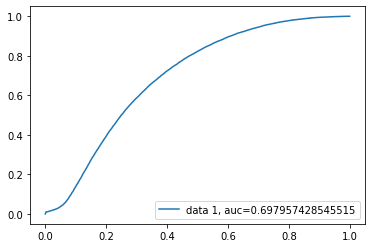

In [31]:
#here auc can be another measure how useful our prediction is
#note: 1 = 100% accurate,  0.5 = useless
y_pred_proba = log_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()